# IMPLEMENTING DECISION TREE REGRESSION USING MEAN SQUARED ERROR
## Hyperparameters:-
- criterion = mse
- min_samples = 2(default)
- max_depth = None(default)

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [1317]:
class Decision_Tree_Regressor:
    def __init__(self, criterion = 'mse', min_samples = 2, max_depth = None):
        self.criterion = criterion
        self.min_samples = min_samples
        self.max_depth = max_depth
        print(f'Criterion: {self.criterion}')
        print(f'Minimum samples for split: {self.min_samples}')
        print(f'Maximum depth of Tree: {self.max_depth}')
        
    #function to fit the tree to the given data---------------------------------------------------------------------    
    def fit(self, X, y, feature_cols = None):
        self.tree = None
        self.X = np.array(X)
        self.y = np.array(y)
        self.depth = 0
        try:
            if isinstance(list(feature_cols), list):
                self.feature_cols = list(feature_cols)
        except:
            self.feature_cols = feature_cols
        data = np.concatenate([self.X, self.y.reshape(1,-1).T], axis = 1)
        return pprint(self.create_tree(data))
        
        

    #function to calculate the mean squared error for a dataset or subset------------------------------------------------------
    def mse(self, data):
        actual = data[:,-1]
        prediction = np.mean(actual)
        total = len(actual)
        #error = np.sqrt(np.var((actual - prediction ), ddof = 0))
        error = np.mean((actual - prediction)**2)
        return error
        
        

    #function to check if the rows of a subset are the same or not----------------------------------------------
    def rows_same(self, data):
        #print(data)
        
        rows = data[:,:-1]
        #print(data_labels)
        if np.isclose(rows, rows[0]).all():
            return True
        else:
            return False
    
    
    #function to find the split values for the features in the given data------------------------------------------ 
    def potential_splits(self, data):
        splits = {}
    
        _, features = data.shape
        for column in range(features - 1):
            unique_values = np.unique(data[:, column])    
            splits[column]=[]
            for i in range(len(unique_values)-1):
                splits[column].append((unique_values[i] + unique_values[i+1])/2)

        return splits
    
    #funtion to split the dataset based on the potential splits----------------------------------------------------
    def split_data(self, data, feature, attribute_split):
        
        data_above = data[data[:, feature] <= attribute_split ]
        data_below = data[data[:, feature] > attribute_split ]
        
        return data_above, data_below
    
    #function the calculate the maximum reduction in mse-------------------------------------------------------------------
    def reduction_mse(self, data_above, data_below, current_mse):
        total = len(data_above) + len(data_below)
        p_data_below = len(data_below) / total
        p_data_above = len(data_above) / total
        mse_after_split = p_data_above * self.mse(data_above) + p_data_below * self.mse(data_below)

        return  current_mse - mse_after_split
        
    #function to find the best splitting node in the decision tree-------------------------------------------------        
    def best_split(self, data):
        best_mse = None
        best_feature = None
        best_value = None
        current_mse = self.mse(data)
        splits = self.potential_splits(data)
        for feature in splits:
#             print('----------------------------------------------------')
#             print('FEATURE: ', feature)
            for value_split in splits[feature]:
#                 print('SPLIT :', value_split)
                #split the data into two based on the current feature--------------------------------------------
                data_above, data_below = self.split_data( data, feature, value_split)
#                 print('data_above:', data_above)
#                 print('data_below:', data_below)
                #calulate information gain for each split 
                reduced_mse = self.reduction_mse(data_above, data_below, current_mse)
#                 print('mse:', reduced_mse)
#                 print('----------------------------------------------')
                #find the best feature and attribute value
                if  best_mse == None or reduced_mse >= best_mse:
                    best_mse = reduced_mse
                    best_feature = feature
                    best_value = value_split
                    
        return  best_feature, best_value
    
    #function to create a leaf node--------------------------------------------------------------------------------
    def create_leaf(self, data, depth = None):
        target = data[:, -1]
        return np.mean(target)
    
    #function to implement the decsion tree algorithm--------------------------------------------------------------
    def create_tree(self, data, depth = 0):
        
        # if data is pure or len(data) is lesser than minimum samples or depth == maxdepth, create a leaf node.
        if self.rows_same(data) or (len(data) < self.min_samples) or (depth == self.max_depth):
            leaf = self.create_leaf(data)
            return leaf


        # recursive part
        else:    
            depth += 1
            self.depth = depth
            # helper functions 
            split_column, split_value = self.best_split(data)
            data_below, data_above = self.split_data(data, split_column, split_value)
            
            if isinstance(self.feature_cols, list):
                question = f'{self.feature_cols[split_column]} <= {split_value}'
            else:
                question = f'X[{split_column}] <= {split_value}'
                
            sub_tree = {question: []}

            
            #creating the left and right subtrees
            yes_answer = self.create_tree(data_below, depth)
            no_answer = self.create_tree(data_above, depth)

            if yes_answer == no_answer:
                sub_tree = yes_answer
            else:
                sub_tree[question].append(yes_answer)
                sub_tree[question].append(no_answer)
            self.tree = sub_tree
            return self.tree
            
    
    #function to predict a sample---------------------------------------------------------------------------------            
    def predict_sample(self, sample, traverse = False):
        if traverse == False:
            traverse_tree = self.tree
        else:
            traverse_tree = traverse
        
        feature, equality, attribute = list(traverse_tree.keys())[0].split()
        if isinstance(self.feature_cols, list):
            feature = self.feature_cols.index(feature)
        else:
            feature = int(feature[2:-1])
        attribute = float(attribute)
        node = list(traverse_tree.keys())[0]

        if sample[feature] <= attribute:
            answer = traverse_tree[node][0]
        else:
            answer = traverse_tree[node][1]

        if not isinstance(answer, dict):
            return answer
        else:
            traverse_tree = answer
            return self.predict_sample(sample, traverse = answer)
              
    #function to predict a subset of samples-----------------------------------------------------------------------
    def predict(self, samples):
        samples = np.array(samples)
        return np.array([self.predict_sample(sample) for sample in samples])
    
    
    #function to calculate the R2 Score of the model---------------------------------------------------------------    
    def r2_score( self, actual, prediction):
        actual = np.array(actual)
        prediction = np.array(prediction)
        ss_residual = sum((actual - prediction)** 2)
        ss_total = sum((actual - np.mean(actual))** 2)
        r2 = 1 - ss_residual/ ss_total
        return r2
            
            

## Let's apply our regressor to an advertising dataset

In [1338]:
ad = pd.read_csv('advertising.csv')
ad.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


## Instantiating the model

In [1319]:
reg = Decision_Tree_Regressor()
reg

Criterion: mse
Minimum samples for split: 2
Maximum depth of Tree: None


## Applying Train Test Split

In [1320]:
X_train, X_test, y_train, y_test = train_test_split(ad.drop('Sales', axis = 1), ad['Sales'], test_size=0.2, random_state = 1)

In [1339]:
X_train.head()

,TV,Radio,Newspaper
108,13.1,0.4,25.6
107,90.4,0.3,23.2
189,18.7,12.1,23.4
14,204.1,32.9,46.0
56,7.3,28.1,41.4


In [1340]:
X_test.head()

,TV,Radio,Newspaper
58,210.8,49.6,37.7
40,202.5,22.3,31.6
34,95.7,1.4,7.4
102,280.2,10.1,21.4
184,253.8,21.3,30.0


In [1322]:
ad.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales'], dtype='object')

## Fitting the model to our data

In [1341]:
reg.fit(X_train, y_train, feature_cols = ad.columns)

{'TV <= 150.65': [{'TV <= 30.05': [{'Newspaper <= 14.350000000000001': [{'TV <= 4.75': [{'Newspaper <= 7.199999999999999': [3.2,
                                                                                                                            1.6]},
                                                                                        {'Newspaper <= 1.55': [4.8,
                                                                                                               {'Newspaper <= 5.75': [5.7,
                                                                                                                                      5.3]}]}]},
                                                                        {'Newspaper <= 58.25': [{'TV <= 17.549999999999997': [{'Radio <= 32.5': [{'TV <= 15.2': [{'Newspaper <= 33.5': [5.3,
                                                                                                                                                       

## Same tree but with a depth of 3

In [1358]:
reg = Decision_Tree_Regressor(max_depth = 3)
reg.fit(X_train, y_train, feature_cols = ad.columns)

Criterion: mse
Minimum samples for split: 2
Maximum depth of Tree: 3
{'TV <= 150.65': [{'TV <= 30.05': [{'Newspaper <= 14.350000000000001': [4.119999999999999,
                                                                        7.322222222222223]},
                                   {'TV <= 67.65': [10.088235294117645,
                                                    12.902222222222223]}]},
                  {'Radio <= 41.5': [{'Radio <= 10.3': [16.936842105263157,
                                                        19.440476190476186]},
                                     {'TV <= 218.35000000000002': [22.128571428571426,
                                                                   25.471428571428568]}]}]}


## Predicting the Test_Set targets

In [1342]:
pred = reg.predict(X_test)
pred

array([22.6, 18.3, 10.1, 17.9, 20.7, 26.2, 16.5, 17.1, 11.3, 18. , 16. ,
       10.9, 17. , 15.3, 17.9, 16. , 12.4, 17.5,  5.3, 17. , 11.9, 13.3,
        7. , 13.2, 12.3, 19.7,  9.7, 20.7, 20.7, 20.7, 21.8, 16.7, 15.2,
       16.4, 20.2, 19.7, 17. , 10.4, 21.7,  6.9])

In [1343]:
y_test.values

array([23.8, 16.6, 11.9, 19.8, 17.6, 25.5, 16.9, 17.9, 10.5, 17.1, 17.5,
       11.3, 17.4, 16.7, 18.4, 15.9, 12.9, 17.8,  9.5, 18.4, 10.7, 12.5,
        8.5, 11.5, 11.9, 19.9, 10.1, 18.9, 19.6, 20.9, 23.2, 16.9, 17.3,
       16.7, 20.2, 20.5, 16.5, 11. , 22.3,  7.6])

## Now let's plot the predicted vs actual sales values

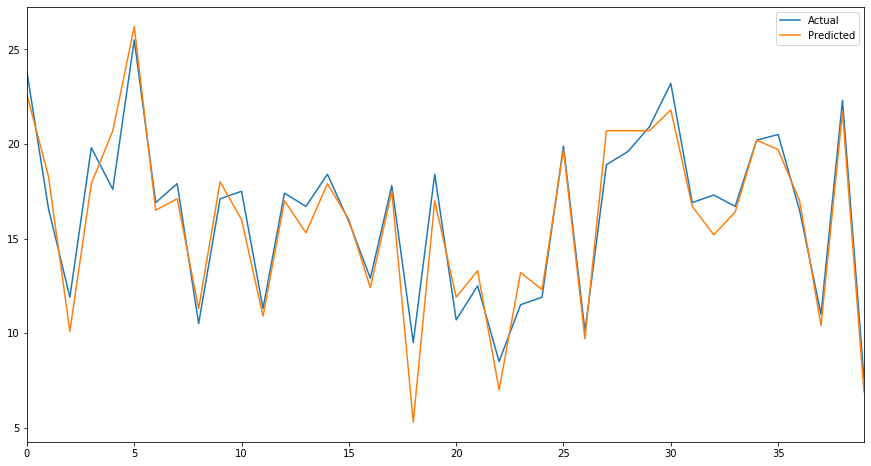

In [1348]:
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
plot_df.reset_index(drop = True).plot(figsize = (15,8))

## R2 Score for the model

In [1352]:
reg.r2_score(y_test, pred)

0.9103967054897779

## Verifying the above model with sklearns DecisionTreeRegressor

In [1353]:
from sklearn.tree import DecisionTreeRegressor
dcr = DecisionTreeRegressor(max_depth = None)
dcr

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [1354]:
dcr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [1355]:
dcr.predict(X_test)

array([23.7, 18.3,  9.4, 18.2, 20.7, 25.4, 16. , 17.1, 11.3, 18. , 16. ,
       10.9, 17. , 15.3, 18.4, 16. , 12.2, 17. ,  4.8, 17.3, 11.9, 13.3,
        7. , 13.2, 12.3, 19.7, 10.1, 20.7, 20.7, 20.7, 21.8, 16.7, 15.2,
       16.4, 20.8, 20.9, 17.2, 11.6, 21.7,  6.6])

In [1356]:
y_test.values

array([23.8, 16.6, 11.9, 19.8, 17.6, 25.5, 16.9, 17.9, 10.5, 17.1, 17.5,
       11.3, 17.4, 16.7, 18.4, 15.9, 12.9, 17.8,  9.5, 18.4, 10.7, 12.5,
        8.5, 11.5, 11.9, 19.9, 10.1, 18.9, 19.6, 20.9, 23.2, 16.9, 17.3,
       16.7, 20.2, 20.5, 16.5, 11. , 22.3,  7.6])

In [1357]:
r2_score(y_test, dcr.predict(X_test))

0.9033641532875394

## Displaying same tree of depth 3 using sklearn and graphviz

In [1363]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(dcr, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)

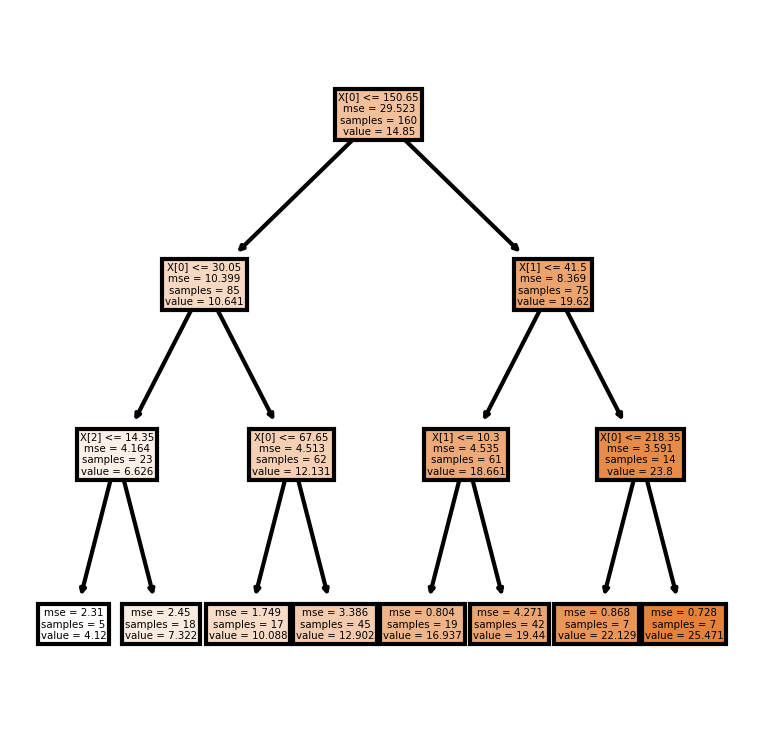

In [1362]:
from sklearn import tree
import matplotlib.pyplot as plt
dcr = DecisionTreeRegressor(max_depth = 3)
dcr.fit(X_train, y_train)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
tree.plot_tree(dcr, filled = True)
fig.savefig('regression_tree.png')